# Diamond Price Prediction

## 1. Problem Statement
This is my first attempt at doing a project. The dataset for this is the og diamon price prediction consisting of more than 50,000 observations. I found this dataset good for practicing regression, and I like predicting price. The goal is to build a regression model for predicting the price, based on a number of physical characteristics of the diamond (cut, carat, color, clarity, dimensions, etc.). This model may help jewelers for easing assessing the diamond price for fair value. Along the way I would try some EDA for any insights

The project will go over these steps:
- Dataset Overview
- Data Cleaning
- Exploratory Data Analysis (EDA)
- Data Preprocessing
- Model Selection
- Model Training
- Evaluation Metrics
- Residual Analysis
- Insights
- Next steps?

In [415]:
# Data handling
import pandas as pd
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
import numpy as np

# Models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Preprocess
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer

import warnings
warnings.filterwarnings('ignore')

# Data import from seaborn built-in dataset
diamonds = sns.load_dataset('diamonds')
df = diamonds.copy()
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


## 2. Data Overview

Diamond dataset consists of ~ 54,000 observations with 10 features. Key columns are:
- **Numerical**: carat, depth, table, x, y, z
- **Categorical**: cut, color, clarity
- **Target**: price(USD)

| Feature     | Type        | Description                                           | Impact on Price                           |
|-------------|-------------|-------------------------------------------------------|--------------------------------------------|
| `carat`     | Numerical   | Weight of the diamond in carats (size).               | 📈 Strong positive - bigger = pricier        |
| `cut`       | Categorical | Quality of cut: Fair, Good, Very Good, Premium, Ideal | 🟡 Moderate - better cut = more value        |
| `color`     | Categorical | Diamond color from D (best) to J (worst)              | 🔻 Slight - D-F are colorless, J is not      |
| `clarity`   | Categorical | Purity: I1 (low) to IF (flawless)                     | 📈 More clarity = higher pricee              |
| `depth`     | Numerical   | Total depth % (z/ mean(x, y)) * 100                   | 🟠 Weak/moderate - affects light reflection  |
| `table`     | Numerical   | Width of top facet as % of diameter                   | 🟠 Moderate - ideal range preferred          |
| `x`         | Numerical   | Length (mm)                                           | 🔁 Correlates with size/carat                |
| `y`         | Numerical   | Width (mm)                                            | 🔁 Correlates with size/carat                | 
| `z`         | Numerical   | Depth (mm)                                            | 🔁 Correlates with size/carat                |
| `price`     | Numerical   | Price in USD - the target variable                    | Target                                    |


In [416]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   carat    53940 non-null  float64 
 1   cut      53940 non-null  category
 2   color    53940 non-null  category
 3   clarity  53940 non-null  category
 4   depth    53940 non-null  float64 
 5   table    53940 non-null  float64 
 6   price    53940 non-null  int64   
 7   x        53940 non-null  float64 
 8   y        53940 non-null  float64 
 9   z        53940 non-null  float64 
dtypes: category(3), float64(6), int64(1)
memory usage: 3.0 MB


In [417]:
df.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


Potential outliers in some features: carat, price, y, z

## 3. Data Cleaning

- Find if there is missing or duplicated

In [418]:
df.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [419]:
df.duplicated().sum()

np.int64(146)

Seems there are a few duplicated rows, let's see what's duplicated in these rows

In [420]:
df[df.duplicated()]

,carat,cut,color,clarity,depth,table,price,x,y,z
1005,0.79,Ideal,G,SI1,62.3,57.0,2898,5.90,5.85,3.66
1006,0.79,Ideal,G,SI1,62.3,57.0,2898,5.90,5.85,3.66
1007,0.79,Ideal,G,SI1,62.3,57.0,2898,5.90,5.85,3.66
1008,0.79,Ideal,G,SI1,62.3,57.0,2898,5.90,5.85,3.66
2025,1.52,Good,E,I1,57.3,58.0,3105,7.53,7.42,4.28
...,...,...,...,...,...,...,...,...,...,...
47969,0.52,Ideal,D,VS2,61.8,55.0,1919,5.19,5.16,3.20
49326,0.51,Ideal,F,VVS2,61.2,56.0,2093,5.17,5.19,3.17
49557,0.71,Good,F,SI2,64.1,60.0,2130,0.00,0.00,0.00
50079,0.51,Ideal,F,VVS2,61.2,56.0,2203,5.19,5.17,3.17


It seems that these rows are essentially have the exact same values. Hence I would drop

In [421]:
df.drop_duplicates(inplace=True)

In [422]:
# Checking again for clarity
df.duplicated().sum()

np.int64(0)

## 4. Exploraty Data Analysis (EDA)

Let's find some insights and see if I can draw some grounds before modeling

In [423]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [424]:
# Lists of numerical columns and categorical columns for future reference
numerical_cols = df.select_dtypes(include=['int', 'float']).columns.tolist()
numerical_cols.remove('price')
categorical_cols = df.select_dtypes(exclude=['int', 'float']).columns.tolist()
print(numerical_cols, categorical_cols)

['carat', 'depth', 'table', 'x', 'y', 'z'] ['cut', 'color', 'clarity']


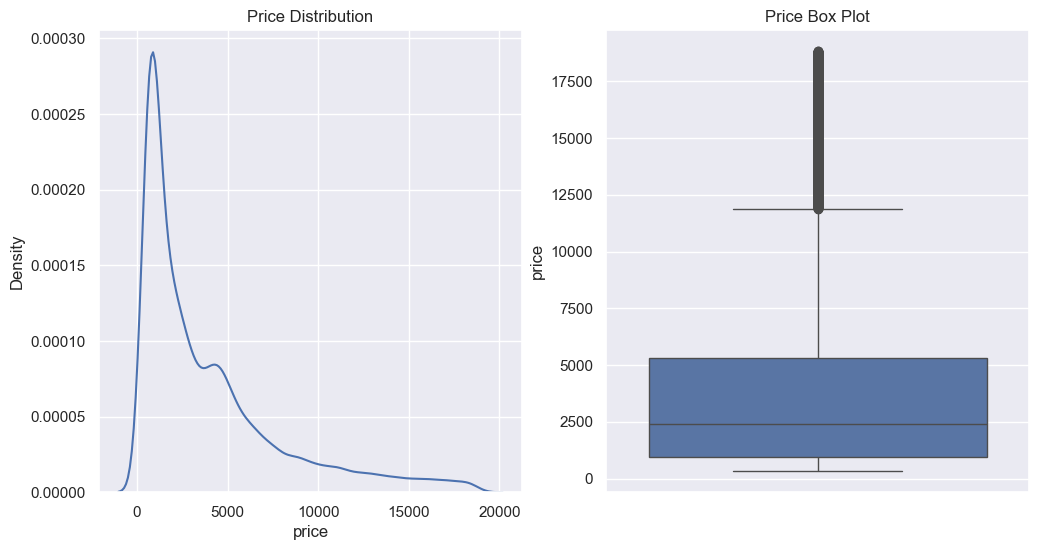

In [425]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
sns.kdeplot(df['price'])
plt.title('Price Distribution')
plt.subplot(1, 2, 2)
sns.boxplot(df['price'])
plt.title('Price Box Plot')
plt.show()

Price is right skewed. This would affect models that assume **normality** such as **Linear Regression**. For better performance of the model, I will also create a log-transfomed target.

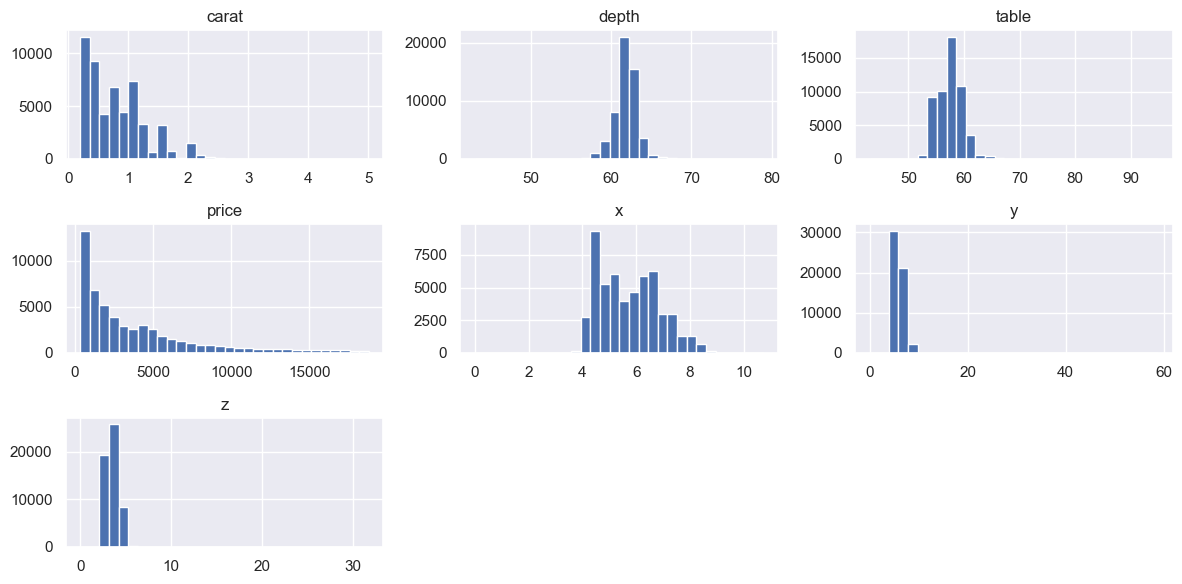

In [426]:
df.hist(figsize=(12,6), bins=30)
plt.tight_layout()
plt.show()

Carat, price, z, y seems not normally distributed

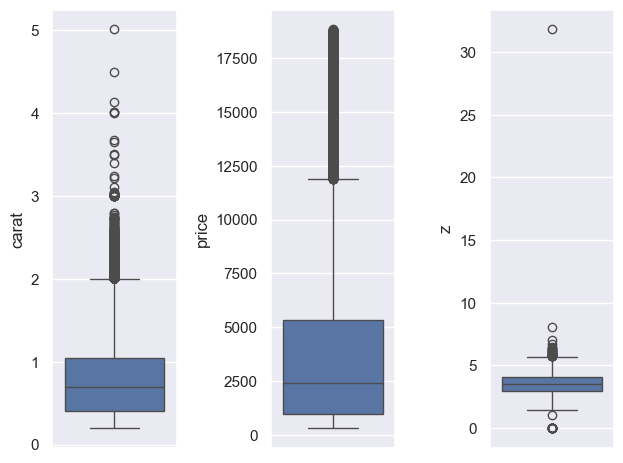

In [427]:
fig, axes = plt.subplots(1, 3)
sns.boxplot(data=df, y='carat', ax=axes[0])
sns.boxplot(data=df, y='price', ax=axes[1])
sns.boxplot(data=df, y='z', ax=axes[2])
plt.tight_layout()
plt.show()

From the histogram and the boxplot, carat, price, y, z all have outliers.

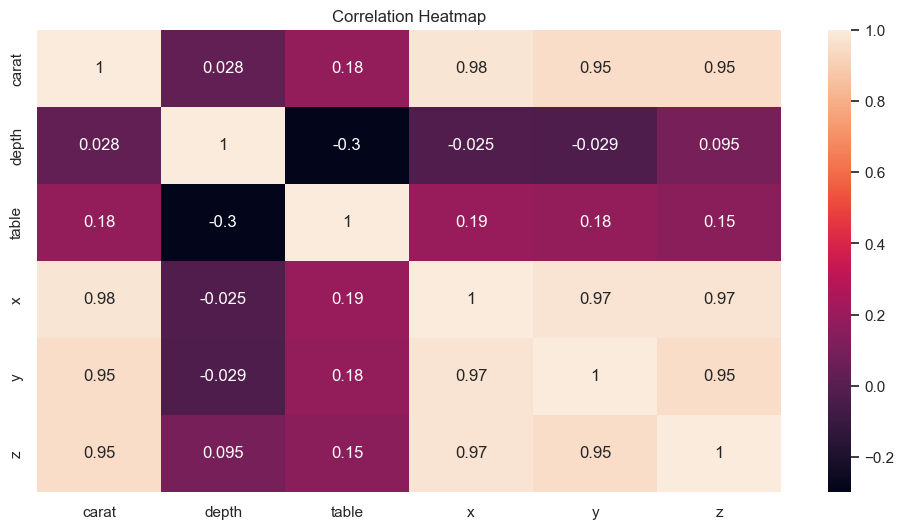

In [428]:
# Heatmap for correlation
plt.figure(figsize=(12,6))
sns.heatmap(df[numerical_cols].corr(), annot=True)
plt.title('Correlation Heatmap')
plt.show()

A pairplot for further inspecting correlations

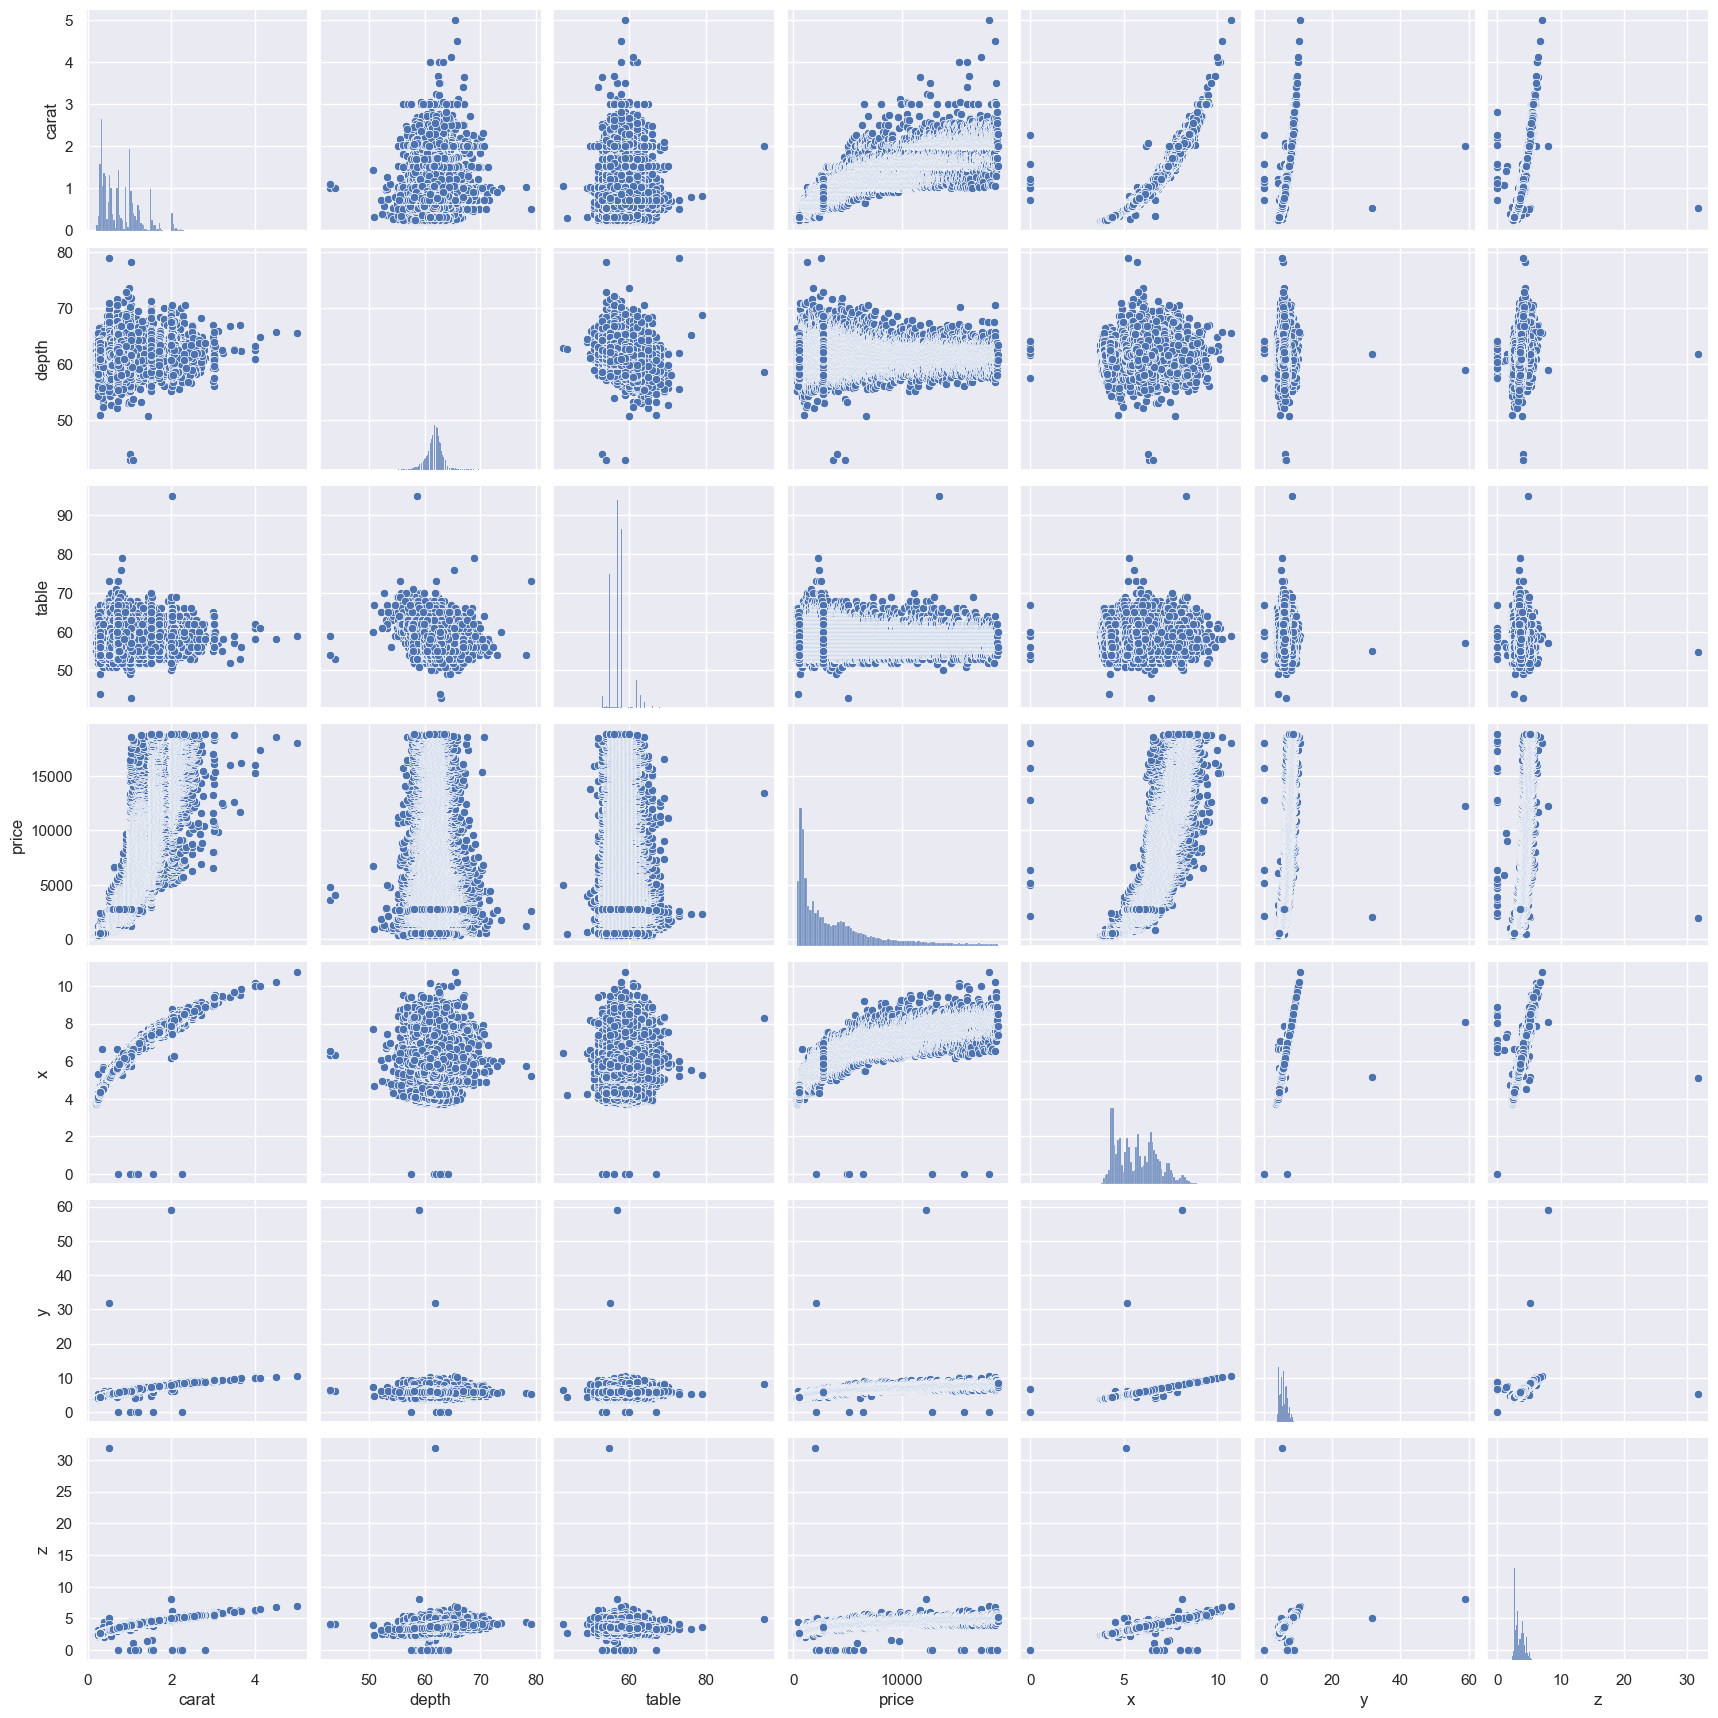

In [429]:
sns.pairplot(df)
plt.show()

It seems like price, x, y, z and carat are highly correlated with each other. This is ground for linear regression as it assumes linearity, normality , homoscedasticity, but there are multicollinearity (between x, y, z, and carat). Hence, Ridge would be a better choice.

Further, y, z, depth, and table should be dived into for outliers.

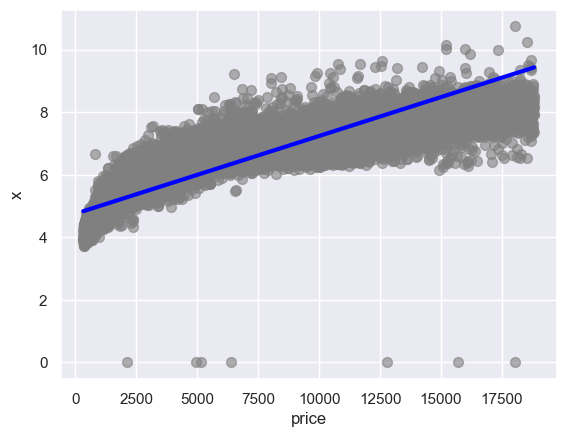

In [430]:
sns.regplot(data=df, x='price', y='x', scatter_kws={'color': 'gray', 's': 50, 'alpha': 0.6}, line_kws={'color': 'blue', 'linewidth': 3})
plt.show()

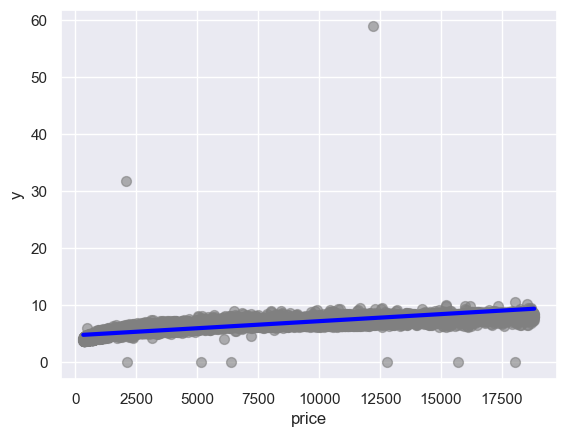

In [431]:
sns.regplot(data=df, x='price', y='y', scatter_kws={'color': 'gray', 's': 50, 'alpha': 0.6}, line_kws={'color': 'blue', 'linewidth': 3})
plt.show()

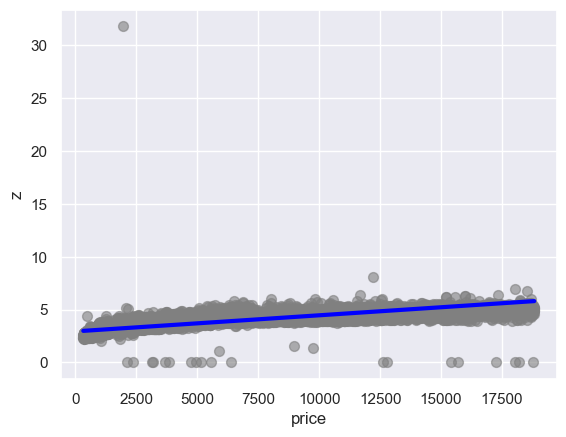

In [432]:
sns.regplot(data=df, x='price', y='z', scatter_kws={'color': 'gray', 's': 50, 'alpha': 0.6}, line_kws={'color': 'blue', 'linewidth': 3})
plt.show()

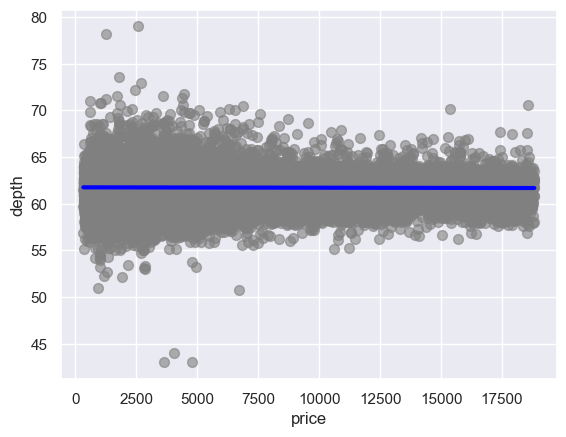

In [433]:
sns.regplot(data=df, x='price', y='depth', scatter_kws={'color': 'gray', 's': 50, 'alpha': 0.6}, line_kws={'color': 'blue', 'linewidth': 3})
plt.show()

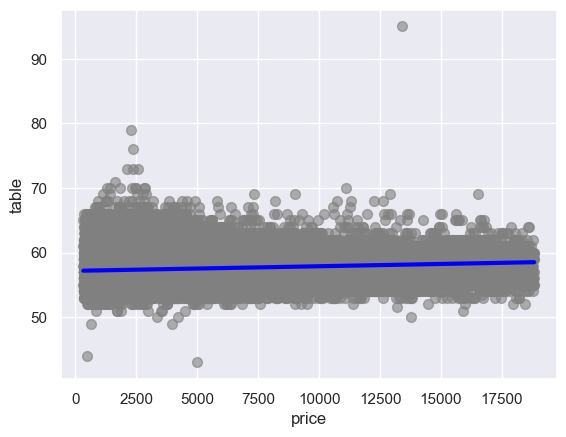

In [434]:
sns.regplot(data=df, x='price', y='table', scatter_kws={'color': 'gray', 's': 50, 'alpha': 0.6}, line_kws={'color': 'blue', 'linewidth': 3})
plt.show()

We can clearly see the outliers, hence I will drop it to enhance model.

In [435]:
df = df[(df['depth'] < 75) & (df['depth'] > 45)]
df = df[(df['table'] < 80) & (df['table'] > 45)]
df = df[(df['z'] < 30) & (df['z'] > 0)]
df = df[df['y'] < 30]
df = df[df['x'] > 2]

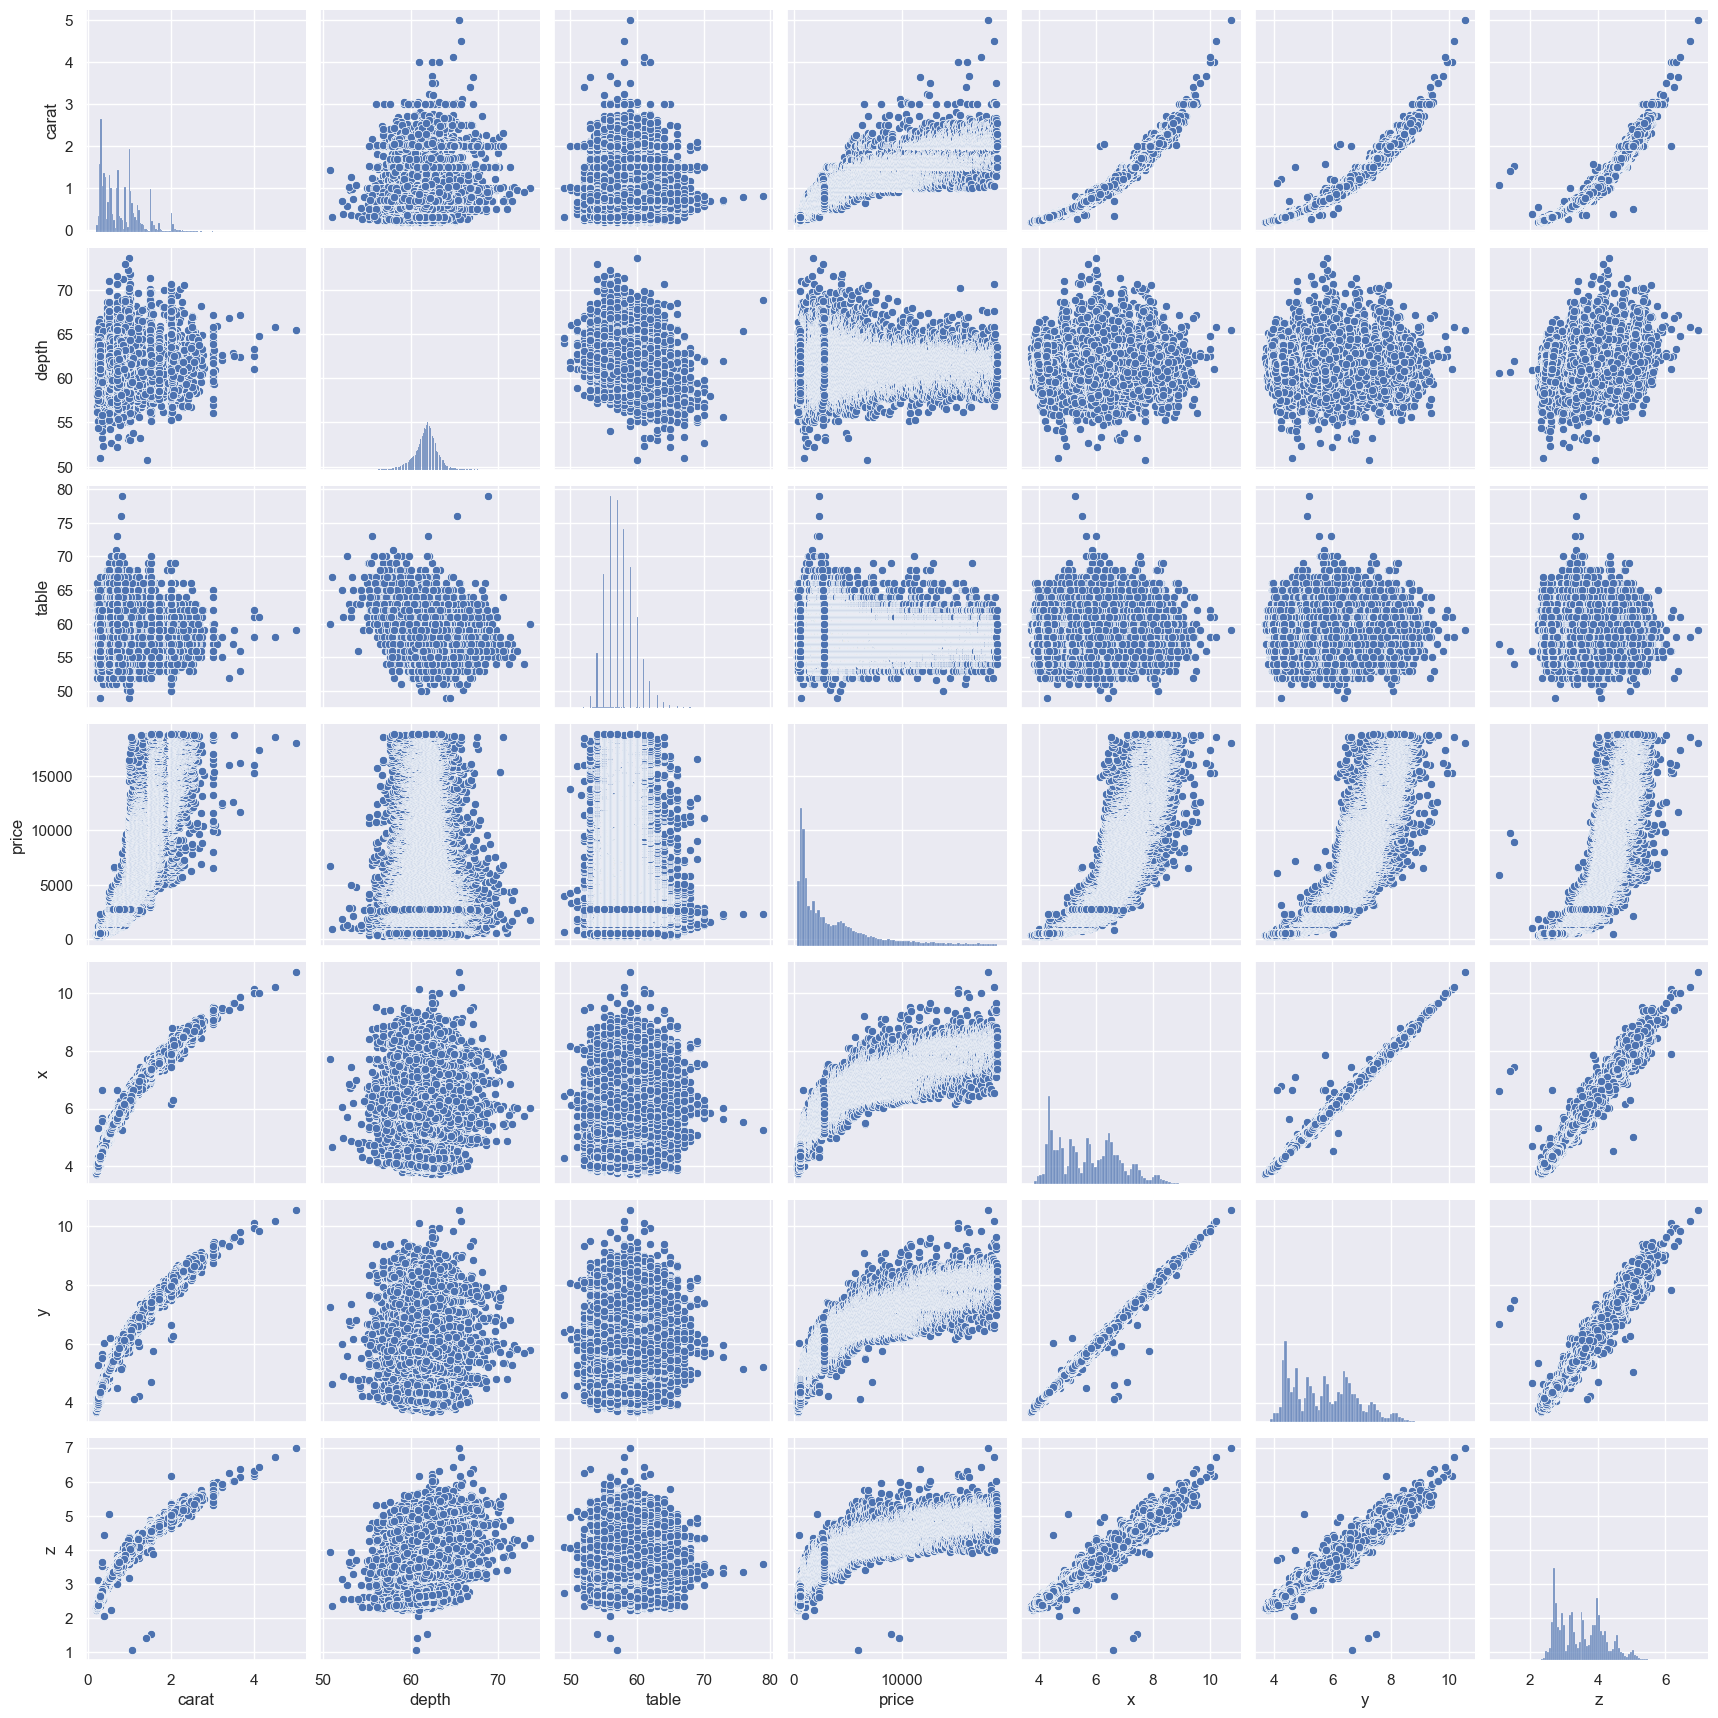

In [436]:
# Take a look at the data again
sns.pairplot(df)
plt.show()

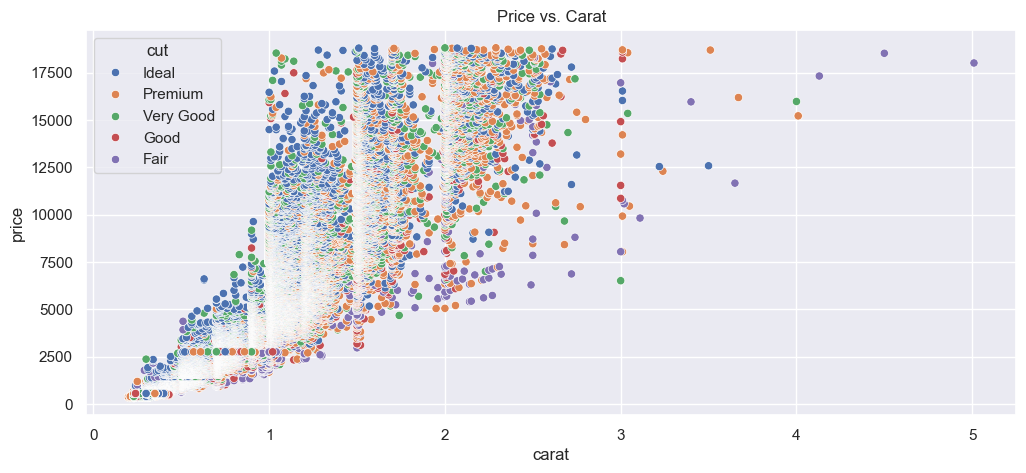

In [437]:
plt.figure(figsize=(12,5))
sns.scatterplot(data=df, x='carat', y='price', hue='cut')
plt.title('Price vs. Carat')
plt.show()

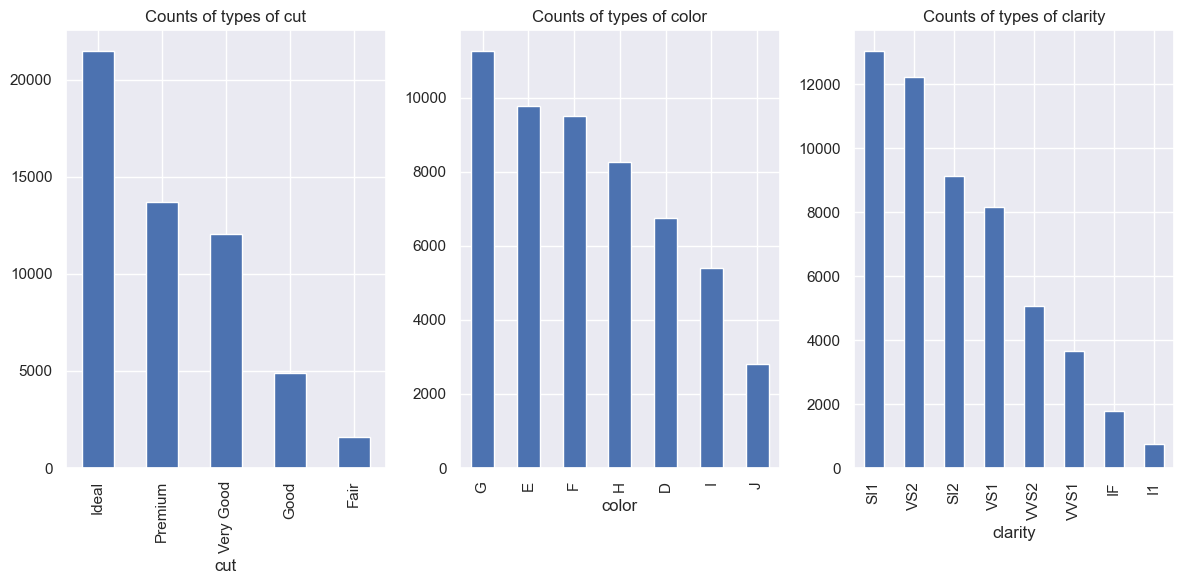

In [438]:
plt.figure(figsize=(12,6))

plt.subplot(1, 3, 1)
df['cut'].value_counts().plot(kind='bar')
plt.title('Counts of types of cut')

plt.subplot(1, 3, 2)
df['color'].value_counts().plot(kind='bar')
plt.title('Counts of types of color')

plt.subplot(1, 3, 3)
df['clarity'].value_counts().plot(kind='bar')
plt.title('Counts of types of clarity')

plt.tight_layout()
plt.show()

The most common cut is ideal, color is G (that is the middle value from D-J), and SI1 (which is slightly included (1st level)). Drawing from this, the majority of diamonds come from middle tier features, while the most few diamonds have either a low or high values or a combination of cut, color, and clarity.

-> Drawing from this, we can select a combination of the most count features for assessing a diamond to understand its rarity.

However, this may raise the problem of imbalanced features. Class weighting, normalization, transformation, or tree-based models may help.

Let's dive deeper into some of this combinations that I think may make our price target skewed.

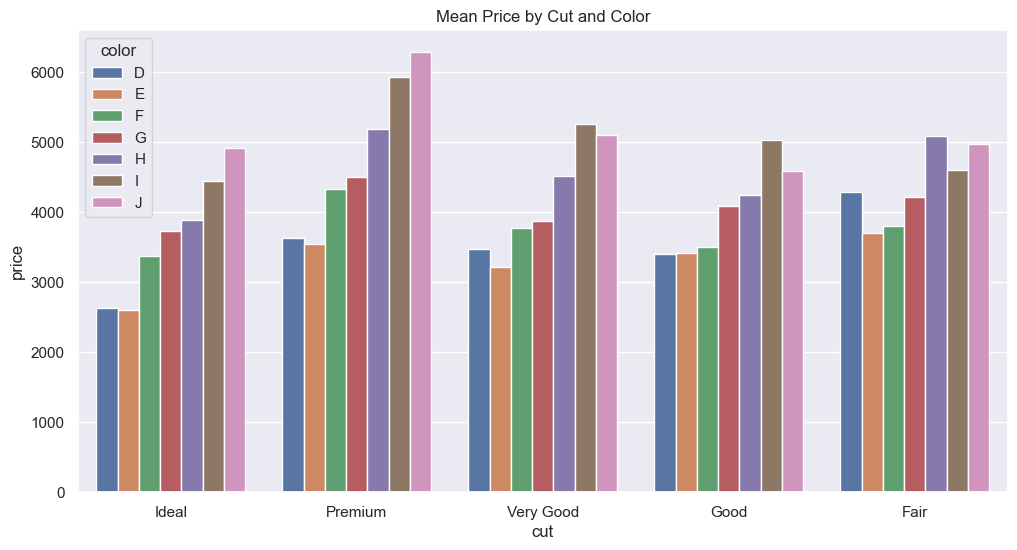

In [439]:
plt.figure(figsize=(12,6))
sns.barplot(data=df.groupby(['cut', 'color'])['price'].mean().reset_index(), x='cut', y='price', hue='color')
plt.title('Mean Price by Cut and Color')
plt.show()

We can select a few of these for foremost predicting price:
- color J has the highest price when compare with cut
- An ideal cut, color H-J has price ratio of around **4,000 to 5,000**.
- A premium cut, color H-J has price average from **5,000 to over 6,000**.
- Very good, good, and fair has quite **similar pattern** of price behavior across the type of colors, with fair having higher price compare to the aforementioned choices.

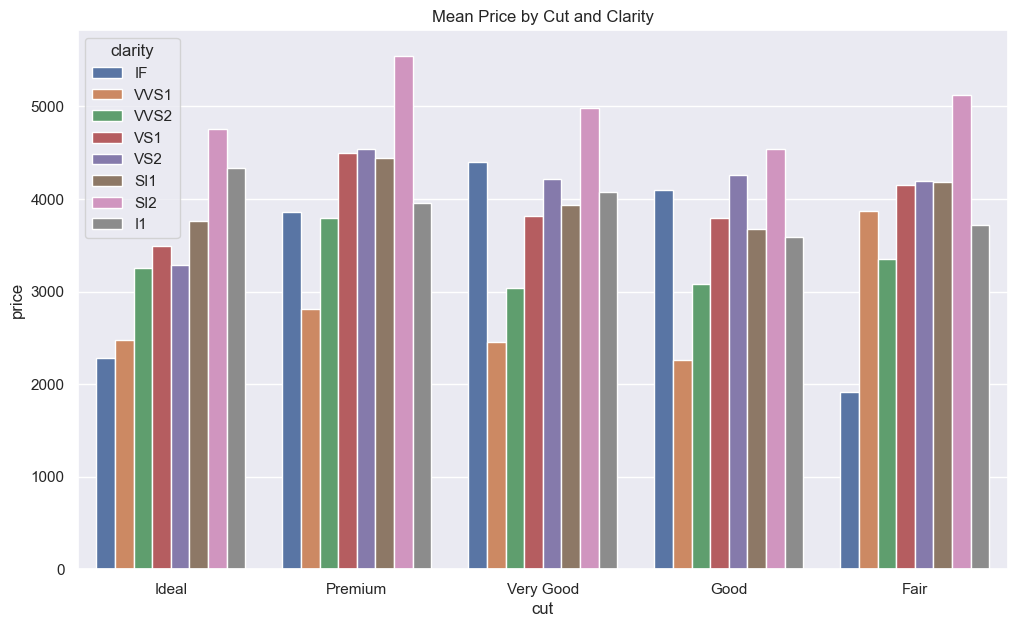

In [440]:
plt.figure(figsize=(12,7))
sns.barplot(data=df.groupby(['cut', 'clarity'])['price'].mean().reset_index(), x='cut', y='price', hue='clarity')
plt.title('Mean Price by Cut and Clarity')
plt.show()

- SI2 has the highest price when compare with cut
- An ideal cut with the type of clarity from **best to worst**  has a **price pattern increase**.
- For premium, very good, good, and fair, the price pattern is considered to be similar, with some flaws.
- Premium has highest price of SI2, lowest price of VVS1
- Very good has highest price of SI2, lowest of VVS1
- Good share the similar patterns
- Fair has the same highest pattern ,only that the lower end is the IF clarity

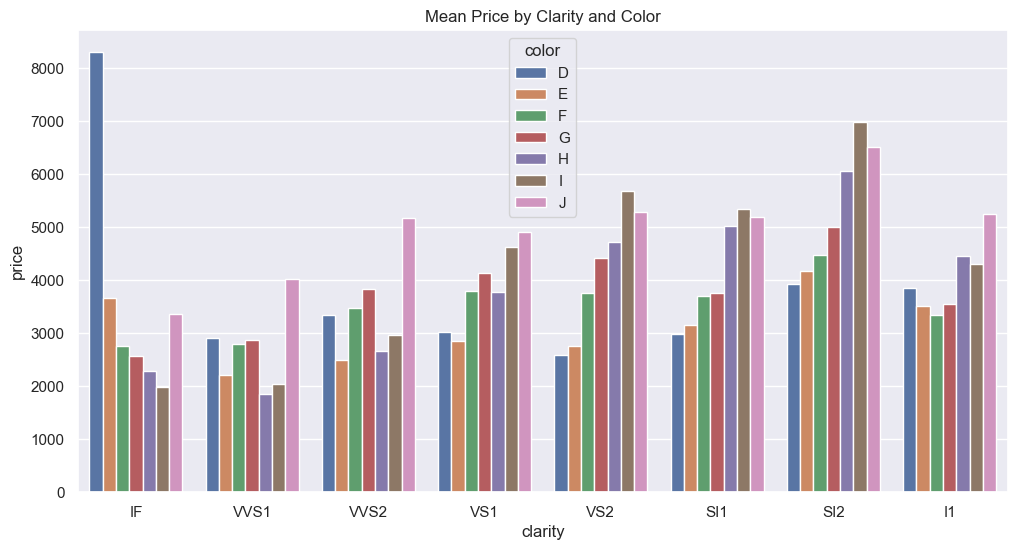

In [441]:
plt.figure(figsize=(12,6))
sns.barplot(data=df.groupby(['color', 'clarity'])['price'].mean().reset_index(), x='clarity', y='price', hue='color')
plt.title('Mean Price by Clarity and Color')
plt.show()

- color D has the highest price when combine with clarity

## 5. Data Preprocessing

Preparing data for modeling. Transforming categorical features and dealing with skew price and colinear features (x, y, z, carat)

In [442]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Since x, y, and z are correlated with each other (each a dimension of the diamond). Hence it would create multicolinearity if I were to created a model with the 3. Hence I would create a volumn column by the product of the 3 columns.

In [443]:
df['volume'] = df['x'] * df['y'] * df['z']

In [444]:
df.select_dtypes(exclude=['number'])

,cut,color,clarity
0,Ideal,E,SI2
1,Premium,E,SI1
2,Good,E,VS1
3,Premium,I,VS2
4,Good,J,SI2
...,...,...,...
53935,Ideal,D,SI1
53936,Good,D,SI1
53937,Very Good,D,SI1
53938,Premium,H,SI2


In [445]:
numerical_cols = df.select_dtypes(include=['number']).loc[:, ['carat', 'depth', 'table', 'volume']].columns.tolist()
categorical_cols = df.select_dtypes(exclude=['number']).columns.tolist()

In [446]:
X = df.drop(columns=['price', 'x', 'y', 'z'])
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

In [447]:
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numerical_transformer = StandardScaler()
preprocessor = ColumnTransformer(
    transformers=[('cat', categorical_transformer, categorical_cols),
                  ('num', numerical_transformer, numerical_cols)]
)

scorer = make_scorer(mean_absolute_error)

pipe = Pipeline([('preprocessor', preprocessor),
                 ('model', RandomForestRegressor(random_state=42))])

param_grid = {
    'model__n_estimators': [50, 100, 200, 300],
    'model__max_depth': [None, 5, 10, 20]
}

grid = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, cv=3, n_jobs=-1, scoring=scorer, n_iter=20)
grid.fit(X_train, y_train_log)

# Best model
print('Best Parameters:', grid.best_params_)
print(f'Best CV MAE: {grid.best_score_:.2f}')

Best Parameters: {'model__n_estimators': 50, 'model__max_depth': 5}
Best CV MAE: 0.16


In [448]:
y_pred_log = grid.predict(X_test)
y_train_pred_log = grid.predict(X_train)
y_pred = np.expm1(y_pred_log)
test_mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {test_mse:.2f}")

Test MSE: 1599470.88


In [449]:
print(f"Train Score: {r2_score(y_train, np.expm1(y_train_pred_log)):.2f}")

Train Score: 0.91


In [450]:
print(f"Test Score: {r2_score(y_test, y_pred):.2f}")

Test Score: 0.90


The model performs quite well (90% of correct predictions). During the first tuning, I use GridSearchCV, with 5 folds, and it took like 10 minutes to compile on my computer. I change to RandomizedSearchCV and the score is quite good. However, I should perform cross_val_score to make a baseline error score for reference.

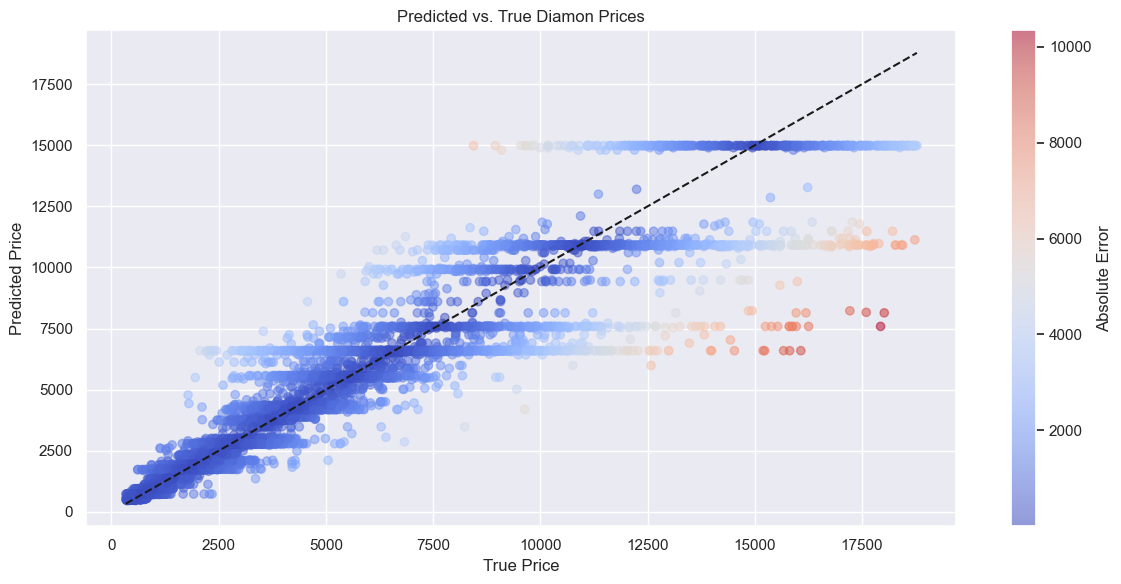

In [451]:
errors = np.abs(y_test - y_pred)

plt.figure(figsize=(12, 6))
scatter = plt.scatter(y_test, y_pred, c=errors, cmap='coolwarm', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.colorbar(scatter, label='Absolute Error')

plt.xlabel('True Price')
plt.ylabel('Predicted Price')
plt.title("Predicted vs. True Diamon Prices")
plt.tight_layout()
plt.show()

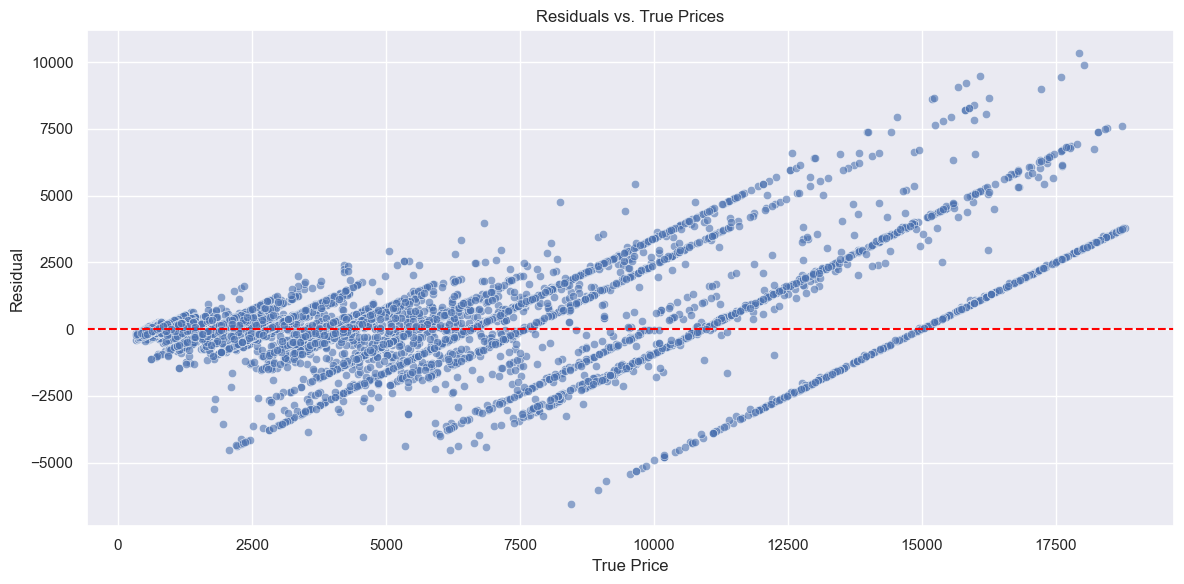

In [452]:
# Residuals
residuals = y_test - y_pred

plt.figure(figsize=(12,6))
sns.scatterplot(x=y_test, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('True Price')
plt.ylabel('Residual')
plt.title('Residuals vs. True Prices')
plt.tight_layout()
plt.show()

We can detect a pattern that as the price gets larger, our model seems to get worse. This may be due to the fact that I have not scaled the price (it's skewed). If you're reading this right now then that means I have changed the price to log, and it seems that the model behaves the same.

I read more and it seems that Random Forest has already handle skewed targets without needing log transforms, since they're non-parametric and don't assume linearity or cosntant variance.

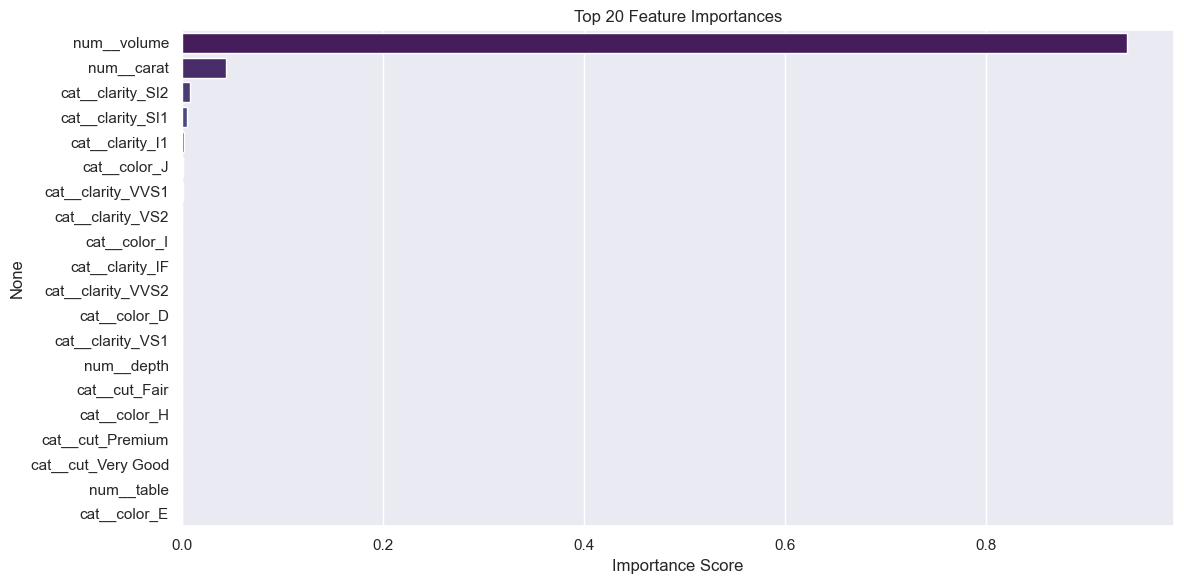

In [453]:
importances = grid.best_estimator_.named_steps['model'].feature_importances_
feature_names = grid.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(20)

plt.figure(figsize=(12, 6))
sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='viridis')
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()


Volumn and Carat are the 2 most important features. And since the 2 correlated with each other, we can do further feature extraction to simplify our model.

## 6. Insights

Overall, the most important features for predicting the price of diamonds largely depends on its volume and carat. Further more, were us as sellers, we can find a combination of the diamond's features (e.g. cut, clarity, color) to have a range of our diamond mean prices.